# Tutorial 07 - Elastic Wave Propagation

## Elastic Forward Simulation

In this notebook we will go through a simple example of setting up an elastic forward simulation in PestoSeis for a 2D overthrust model.  

_This notebook will make reference to the acoustic forward simulation example notebook.  It is thus suggested to work through the acoustic notebook first before giving the elastic case a try._

## Preamble

In [1]:
import pestoseis
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import RectBivariateSpline

## Model Interpolation

Similar to in the acoustic setup, we start by importing the HDF5 (`.h5`) file containing the velocity model.

In [2]:
data_path = "model.h5"
with h5py.File(str(data_path), "r") as f:
    vp = np.array(f["vp"])
    sources = np.array(f["ijsrcs"], dtype=int)
    receivers = np.array(f["ijrecs"], dtype=int)

Since we are considering the same P-wave velocity model in this case as in the purely acoustic case, we will add a conversion using [Gardner's equation](https://doi.org/10.1190/1.1440465) given by

$$
    \rho \approx \alpha (v_p)^\beta
$$

where $\rho$ is density, $v_p$ is the P-wave velocity, and $\alpha$ and $\beta$ are empirically determined quantities.  For this example, we will use $\alpha=0.23$ and $\beta=0.25$.  Care must be taken to first convert $v_p$ to feet/second (using a conversion factor of `0.3048`) and then convert the resulting densities back to metric units in terms of $\text{kg}/\text{m}^3$.

In order to obtain a test dataset of S-wave velocities, an approximate relationship of

$$
    v_s \approx \frac{3}{4}v_p
$$

will be considered.  Please note that this S-wave relationship is simply being used here for the sake of simplicity and would likely not reflect the actual S-wave velocities one might expect to observe in practice.

As was the case for the purely acoustic setup, the data must be interpolated onto a grid with a finer spatial discretization for use with the 50 kHz source time function.

In [3]:
scale = 2

interp_fun = RectBivariateSpline(np.linspace(0, vp.shape[0], vp.shape[0]), np.linspace(0, vp.shape[1], vp.shape[1]), vp)
vp = interp_fun(np.linspace(0, vp.shape[0], vp.shape[0]*scale), np.linspace(0, vp.shape[1], vp.shape[1]*scale))
rho = (0.23 * (vp / 0.3048) ** 0.25)*1000
vs = vp * 3 / 4

sources *= scale
receivers *= scale

Then plotting the results:

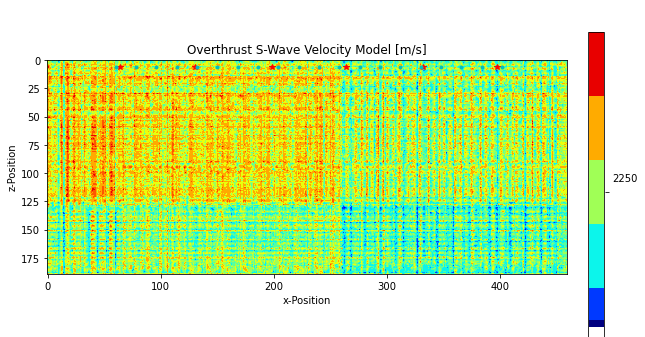

In [4]:
plt.figure(figsize=[10, 16])
im = plt.imshow(vs.T, origin="upper", cmap="jet")
plt.plot(sources[0, :], sources[1, :], "*r")
plt.plot(receivers[0, :], receivers[1, :], ".c")
plt.xlabel("x-Position")
plt.ylabel("z-Position")
plt.title("Overthrust S-Wave Velocity Model [m/s]")
plt.colorbar(im, fraction=0.046*(10/16), pad=0.04)
plt.show()

## Simulation Setup

Next, we can set up the simulation itself.  For this example, we will be explicitly defining the following:
- Time step
- Number of time steps
- Source time function characteristics
- Free surface boundary conditions at the surface of the domain
- PMLs on all other sides

There are two primary differences with this simulation setup compared to the purely acoustic case:
- The first derivative of the source must be taken.  This is due to the time derivative of the source appearing when obtaining the velocity-stress formulation of the elastic wave equation.
- The source is defined in this case as a moment tensor.  Here we will set the off-diagonal terms of the moment tensor to be zero and the diagonal elements to be one (for the sake of simplicity).  That is,
$$
    M =
    \begin{bmatrix}
        1.0 & 0.0\\
        0.0 & 1.0
    \end{bmatrix}
$$

In [5]:
# Temporal discretizationime
t_sim = 0.3
dt = 0.0005
nt = 2000
t = np.arange(0.0, nt*dt, dt)

# Space
nx = vp.shape[0]
nz = vp.shape[1]
dh = 10 / scale # m

# Source
t0 = 0.03
f0 = 25.0
ijsrc = sources[:, 2]
sourcetf = pestoseis.seismicwaves2d.sourcetimefuncs.ricker_1st_derivative_source( t, t0, f0 )
MTens = dict(xx=1.0, xz=0.0, zz=1.0)

# Receivers
nrec = receivers.shape[1]
recpos = receivers.T * dh

# Lamé coefficients
lamb = rho*(vp**2 - 2.0*vs**2) # P-wave modulus
mu = rho*vs**2 # Shear modulus

print(("Receiver positions:\n{}".format(recpos)))

# Initiallize input parameter dictionary
inpar = {}
inpar["ntimesteps"] = nt
inpar["nx"] = nx
inpar["nz"] = nz
inpar["dt"] = dt
inpar["dh"] = dh
inpar["sourcetype"] = "MomTensor"
inpar["momtensor"] = MTens
inpar["savesnapshot"] = True
inpar["snapevery"] = 50
inpar["freesurface"] = True
inpar["boundcond"] = "PML" #"GaussTap"  ## "PML", "GaussTap","ReflBou"
inpar["seismogrkind"] = "velocity"    

# Initiallize dictionary of rock properties
rockprops = {}
rockprops["lambda"] = lamb
rockprops["mu"] = mu
rockprops["rho"] = rho

Receiver positions:
[[ 300.   30.]
 [ 390.   30.]
 [ 480.   30.]
 [ 570.   30.]
 [ 660.   30.]
 [ 750.   30.]
 [ 840.   30.]
 [ 930.   30.]
 [1020.   30.]
 [1110.   30.]
 [1200.   30.]
 [1290.   30.]
 [1380.   30.]
 [1470.   30.]
 [1560.   30.]
 [1650.   30.]
 [1740.   30.]
 [1830.   30.]
 [1920.   30.]
 [2010.   30.]]


## Running the Simulation

Now that we have set up the forward simulation, we can run this using `solveelastic2D` in `pestoseis`.

In [6]:
seism, vxzsave = pestoseis.seismicwaves2d.elasticwaveprop2D.solveelastic2D(inpar, rockprops,ijsrc, sourcetf,f0, recpos)

Starting ELASTIC solver with CPML boundary conditions.
 Source type:  MomTensor
 * Free surface at the top *
 Size of PML layers in grid points: 21 in x and 21 in z
 Time step dt: 0.0005
 Time step 1900 of 2000 
Saved elastic simulation and parameters to  elastic_snapshots.h5


## Plotting the Results

There are a few different options here for plotting the elastic wavefields:
- `PS`: Plot the P- and S-waves
- `VxVz`: Plot the x- and z-components of the velocity fields seperately
- `Vmag`: Plot the magnitude of the combined velocity componenets

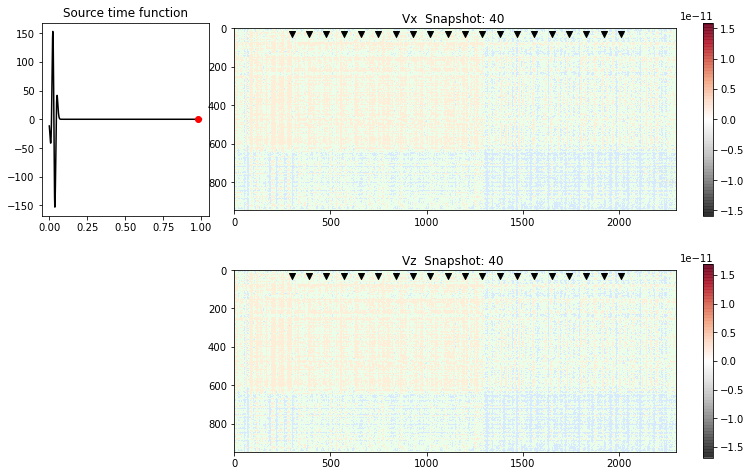

In [7]:
h5_data = "elastic_snapshots.h5"
pestoseis.seismicwaves2d.animatewaves.animateelasticwaves(h5_data, showwhatela="VxVz", clipamplitude=0.05)